In [721]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import csv
import json
from scipy.stats import linregress
from config import api_key

In [808]:
mlb_kaggle_latest = 'Resources/mlb_elo_latest.csv'
mlb_kaggle = 'Resources/mlb_elo.csv'
city_alt_csv = 'output_data/city_altitude.csv'
team_name_csv = 'output_data/team_name.csv'
team_standings_csv = 'output_data/team_standings.csv'
team_key_edit_csv = 'output_data/team_key_edit.csv'
team1_csv = 'Resources/team1_alt.csv'

# Merging api data from sportsdata.io on stadium ID and outputting csv file 

city_alt_df = pd.read_csv(city_alt_csv)
team_name_df = pd.read_csv(team_name_csv)
standings_df = pd.read_csv(team_standings_csv)
team_key_edit_df = pd.read_csv(team_key_edit_csv)
team1_alt_df = pd.read_csv(team1_csv)


complete_ID_df = pd.merge(team_name_df, city_alt_df, how='right', on=['stadium ID', 'stadium ID'])
cleaned_ID_df = complete_ID_df[complete_ID_df['team city'].notna()]
complete_sportsio_df = pd.merge(cleaned_ID_df, standings_df, how='right', on=['team key', 'team key'])
complete_sportsio_df.to_csv('output_data/complete_team_stadium.csv', index=False)

In [723]:
# Kaggle csv data on MLB 
kag_latest_df = pd.read_csv(mlb_kaggle_latest)
kag_og_df = pd.read_csv(mlb_kaggle)
kag_og_df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2021-10-03,2021,0,NaN,ATL,NYM,1520.302033,1511.617803,0.546898,0.453102,...,NaN,NaN,NaN,NaN,0.514740,0.485260,NaN,NaN,NaN,NaN
1,2021-10-03,2021,0,NaN,STL,CHC,1519.691110,1525.797177,0.525729,0.474271,...,NaN,NaN,NaN,NaN,0.527320,0.472680,NaN,NaN,NaN,NaN
2,2021-10-03,2021,0,NaN,SEA,ANA,1479.484611,1478.455457,0.535958,0.464042,...,NaN,NaN,NaN,NaN,0.499610,0.500390,NaN,NaN,NaN,NaN
3,2021-10-03,2021,0,NaN,LAD,MIL,1579.554567,1502.598988,0.641331,0.358669,...,NaN,NaN,NaN,NaN,0.646189,0.353811,NaN,NaN,NaN,NaN
4,2021-10-03,2021,0,NaN,KCR,MIN,1473.202406,1498.953739,0.497480,0.502520,...,NaN,NaN,NaN,NaN,0.472238,0.527762,NaN,NaN,NaN,NaN


In [724]:
# Truncate kaggle MLB csv by season

filtered_data = kag_og_df[(kag_og_df['season'] >= 1910) & (kag_og_df['season'] <= 2019)]
filtered_data.tail()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
192705,1910-04-14,1910,0,NaN,MIN,OAK,1436.723,1543.863,0.382585,0.617415,...,NaN,NaN,NaN,NaN,0.387556,0.612444,1439.717,1540.900,3.0,0.0
192706,1910-04-14,1910,0,NaN,DET,CLE,1549.124,1490.938,0.616117,0.383883,...,NaN,NaN,NaN,NaN,0.617890,0.382110,1546.643,1493.450,7.0,9.0
192707,1910-04-14,1910,0,NaN,CIN,CHC,1498.436,1572.183,0.428894,0.571106,...,NaN,NaN,NaN,NaN,0.431664,0.568336,1499.995,1570.550,1.0,0.0
192708,1910-04-14,1910,0,NaN,CHW,BAL,1517.043,1467.871,0.603773,0.396227,...,NaN,NaN,NaN,NaN,0.607540,0.392460,1518.737,1465.984,3.0,0.0
192709,1910-04-14,1910,0,NaN,ATL,SFG,1444.007,1536.134,0.403195,0.596805,...,NaN,NaN,NaN,NaN,0.408570,0.591430,1445.696,1534.560,3.0,2.0


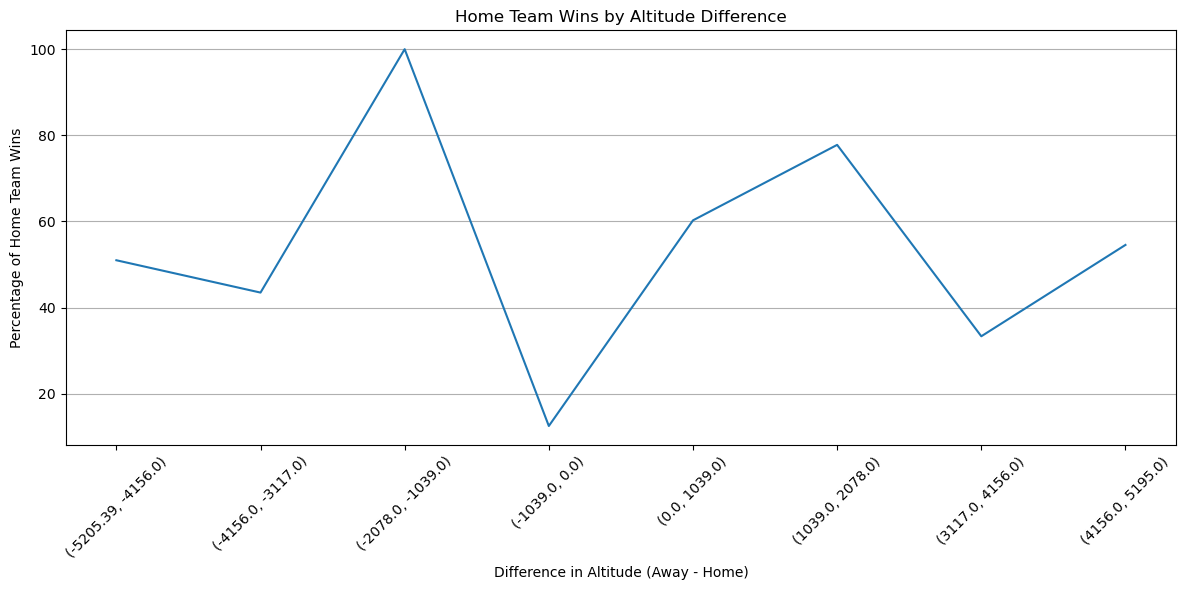

In [1036]:
elevation_df = pd.merge(filtered_data, team_key_edit_df,how='right', on=['team2', 'team2'])
ele_df = pd.merge(elevation_df, team1_alt_df, how='right', on=['team1', 'team1']).dropna()
ele_df.head()

cleaned_df = pd.DataFrame({
    'home team': ele_df['team1'],
    'away team': ele_df['team2'],
    'home team score': ele_df['score1'].astype(int),
    'away team score': ele_df['score2'].astype(int),
    'home altitude': ele_df['home altitude'],
    'away altitude': ele_df['away altitude']
})

cleaned_df['home win'] = cleaned_df['home team score'] > cleaned_df['away team score']
cleaned_df['diff_alt'] = cleaned_df['away altitude'] - cleaned_df['home altitude']
cleaned_df['alt_bins'] = pd.cut(cleaned_df['diff_alt'], bins = 10).astype(str)

bins = ['(-5205.39, -4156.0)','(-4156.0, -3117.0)','(-2078.0, -1039.0)','(-1039.0, 0.0)',
        '(0.0, 1039.0)','(1039.0, 2078.0)','(3117.0, 4156.0)','(4156.0, 5195.0)']

alt_counts = cleaned_df['diff_alt'].value_counts()

home_wins = cleaned_df.loc[cleaned_df['home win'], 'diff_alt'].value_counts()

sorted_bins = cleaned_df['alt_bins'].sort_values().unique()

home_win_percent = cleaned_df.groupby('alt_bins')['home win'].mean() * 100

plt.figure(figsize=(12, 6))
plt.plot(home_win_percent.index, home_win_percent)

plt.xlabel('Difference in Altitude (Away - Home)')
plt.ylabel('Percentage of Home Team Wins')
plt.title('Home Team Wins by Altitude Difference')
plt.xticks(range(len(bins)), bins, rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('output_data/elevation_lineg.png')
plt.show()

        

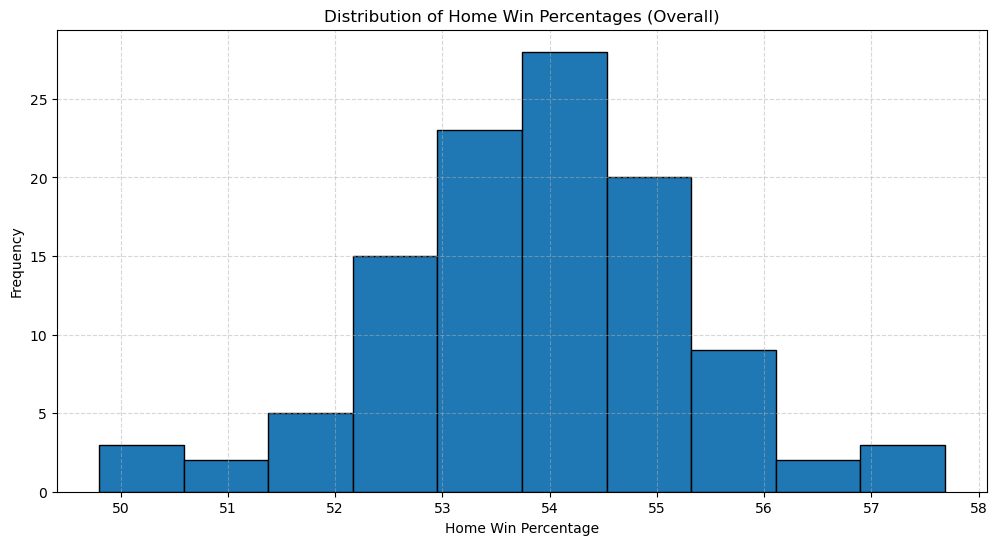

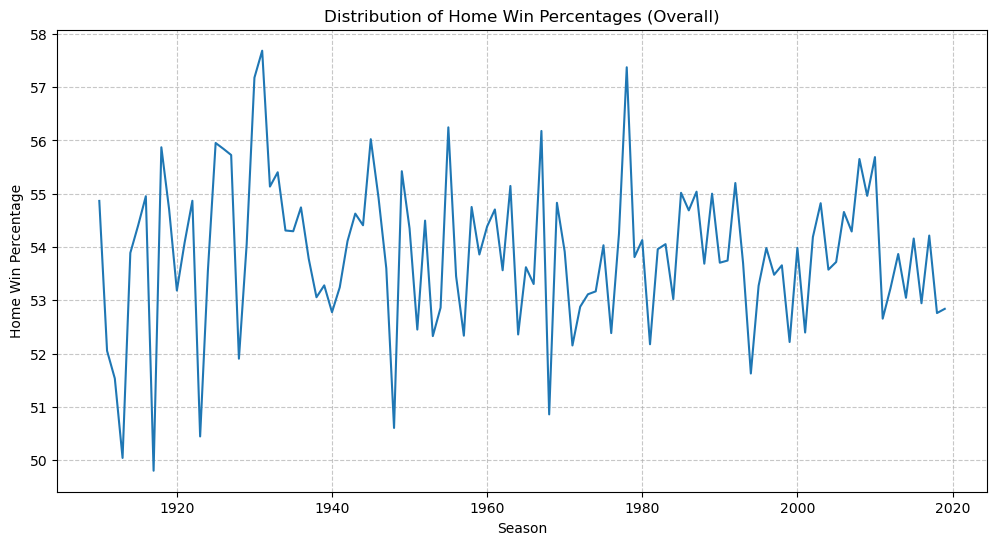

In [988]:
# create function that plots histogram and line graph of % home wins vs season
# Function takes in dataframe, graph title variable and two firgure variables
# total number of games y axis x axis seasons
def home_team_advantage(filtered_data, graph_title, fig1, fig2):
   
    # Create new dataframe with season, home score, and away score
    
    home_clean_df = pd.DataFrame({
        'season': filtered_data['season'],
        'home score': filtered_data['score1'].astype(int),
        'away score': filtered_data['score2'].astype(int),
        'home team': filtered_data['team1'],
        'away team': filtered_data['team2']

    })
    
    # Check if home score is greater than away score
    
    home_clean_df['Home Win'] = (
        home_clean_df['home score'] > home_clean_df['away score'] )
    
    # Check and count home wins vs away wins

    home_win = home_clean_df[home_clean_df['Home Win'] == True]
    away_win = home_clean_df[home_clean_df['Home Win'] == False]

    home_totals = home_win.groupby('season')['Home Win'].count()
    away_totals = away_win.groupby('season')['Home Win'].count()
    
    # Create total home win vs away win df
    
    totals_df = pd.DataFrame({
        'Home Wins': home_totals,
        'Away Wins': away_totals
    })
    

    # Get total matches

    total_matches = totals_df['Home Wins'] + totals_df['Away Wins']
    
    # Calculate percentage of home wins
    
    home_percentage = (totals_df['Home Wins'] / total_matches) * 100
    home_percentage

    
    # Plot histogram
    plt.figure(figsize=(12, 6))

    plt.hist(home_percentage, edgecolor='black')
    plt.xlabel('Home Win Percentage')
    plt.ylabel('Frequency')  
    plt.title(graph_title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(fig1) 
    plt.show()
    
    # Plot line graph
    plt.figure(figsize=(12, 6))

    plt.plot(home_percentage.index, home_percentage.values, linestyle='-')
    plt.xlabel('Season')
    plt.ylabel('Home Win Percentage')  
    plt.title(graph_title) 
    plt.grid(True, linestyle='--', alpha=0.7) 
    plt.savefig(fig2) 
    plt.show()
    return totals_df


# Create title, fig1, fig2 variables

overall_title = 'Distribution of Home Win Percentages (Overall)'
overall_fig1 = 'output_data/overall_fig1.png'
overall_fig2 = 'output_data/overall_fig2.png'

# Invoke function 

home_percentage_overall = home_team_advantage(filtered_data, overall_title, overall_fig1, overall_fig2)


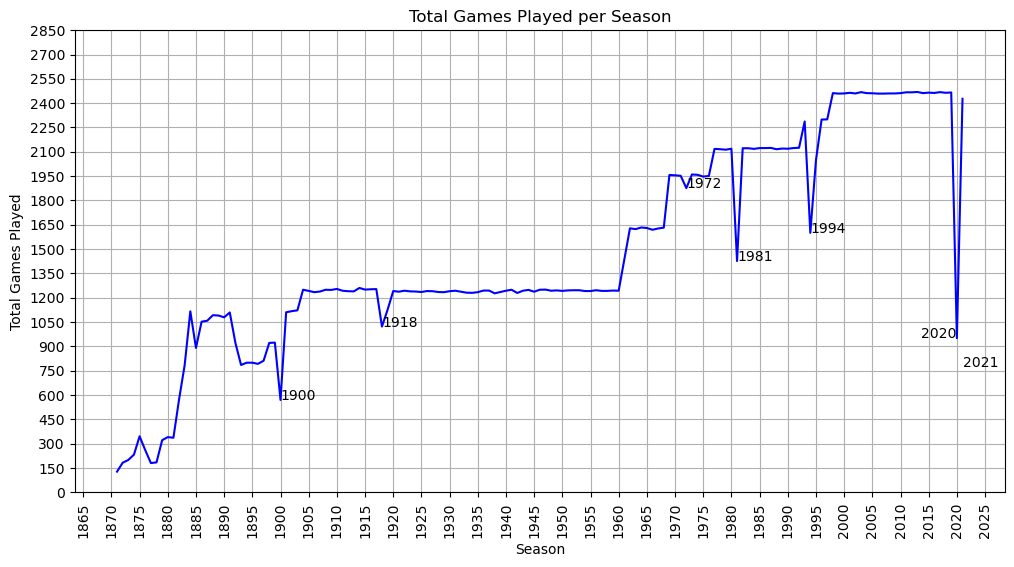

In [989]:
history_df = pd.DataFrame({
    'season': kag_og_df['season'],
    'home score': kag_og_df['score1'],
    'away score': kag_og_df['score2'],
    'home team': kag_og_df['team1'],
    'away team': kag_og_df['team2']

})

# Check if home score is greater than away score

history_df['Home Win'] = (
    history_df['home score'] > history_df['away score'] )

# Check and count home wins vs away wins

home_win = history_df[history_df['Home Win'] == True]
away_win = history_df[history_df['Home Win'] == False]

home_totals = home_win.groupby('season')['Home Win'].count()
away_totals = away_win.groupby('season')['Home Win'].count()

# Create total home win vs away win df

totals_df = pd.DataFrame({
    'Home Wins': home_totals,
    'Away Wins': away_totals
})


# Get total matches

total_matches = totals_df['Home Wins'] + totals_df['Away Wins']

# Calculate percentage of home wins

home_percentage = (totals_df['Home Wins'] / total_matches) * 100
home_percentage

# plot total matches over seasons
plt.figure(figsize=(12, 6))
plt.plot(total_matches.index, total_matches.values, linestyle='-', color='blue')
plt.xlabel('Season')
plt.ylabel('Total Games Played')
plt.title('Total Games Played per Season')
plt.grid(True)
plt.xticks(range(1865,2030,5),rotation=90, fontsize=10) 
plt.yticks(range(0,3000, 150))
plt.text(1900, 569, str(1900), ha='left', va='baseline', color='black')
plt.text(1918, 1022, str(1918), ha='left', va='baseline', color='black')
plt.text(1972, 1875, str(1972), ha='left', va='baseline', color='black')
plt.text(1981, 1426, str(1981), ha='left', va='baseline', color='black')
plt.text(1994, 1600, str(1994), ha='left', va='baseline', color='black')
plt.text(2020, 951, str(2020), ha='right', va='baseline', color='black')
plt.text(2021, 771, str(2021), ha='left', va='baseline', color='black')
plt.savefig('output_data/history_matches.png')
plt.show()

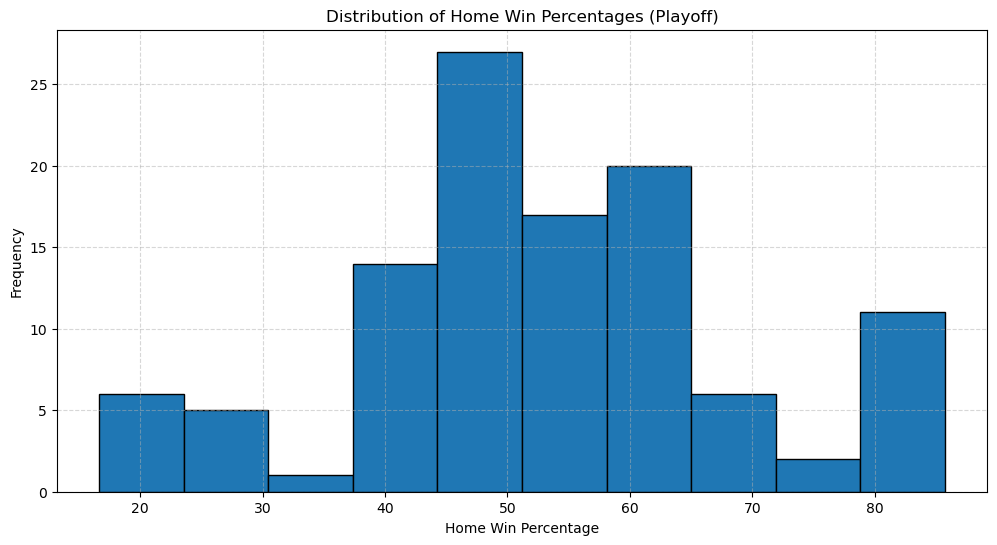

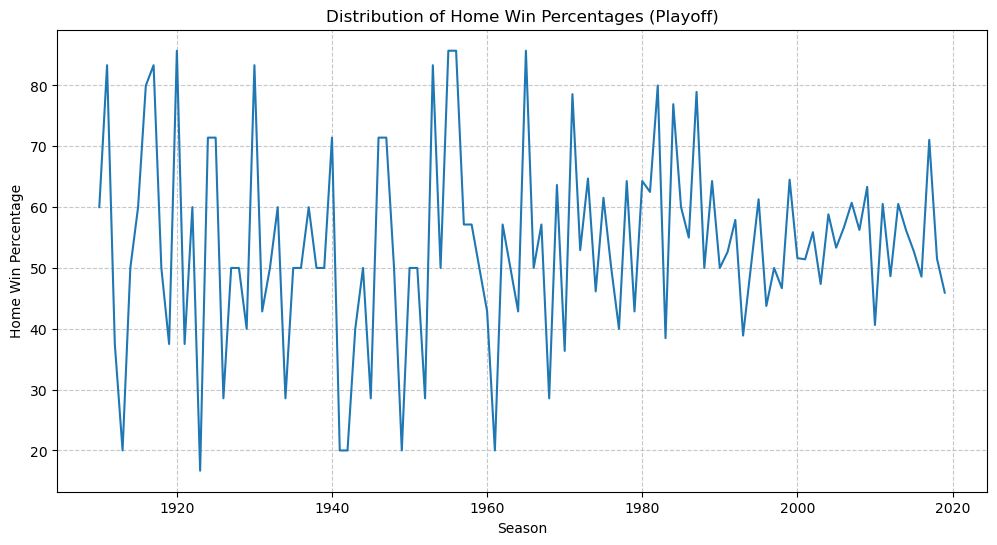

,Home Wins,Away Wins
season,,
1910,3,2
1911,5,1
1912,3,5
1913,1,4
1914,2,2
...,...,...
2015,19,17
2016,17,18
2017,27,11


In [788]:
# Create df with only playoff data

playoff_df = filtered_data[filtered_data['playoff'].notna()]

# Create title, fig1, fig2 variables

playoff_title = 'Distribution of Home Win Percentages (Playoff)'
playoff_fig1 = 'output_data/playoff_fig1.png'
playoff_fig2 = 'output_data/playoff_fig2.png'

# Invoke function 

home_percentage_playoff = home_team_advantage(playoff_df, playoff_title, playoff_fig1, playoff_fig2)
home_percentage_playoff

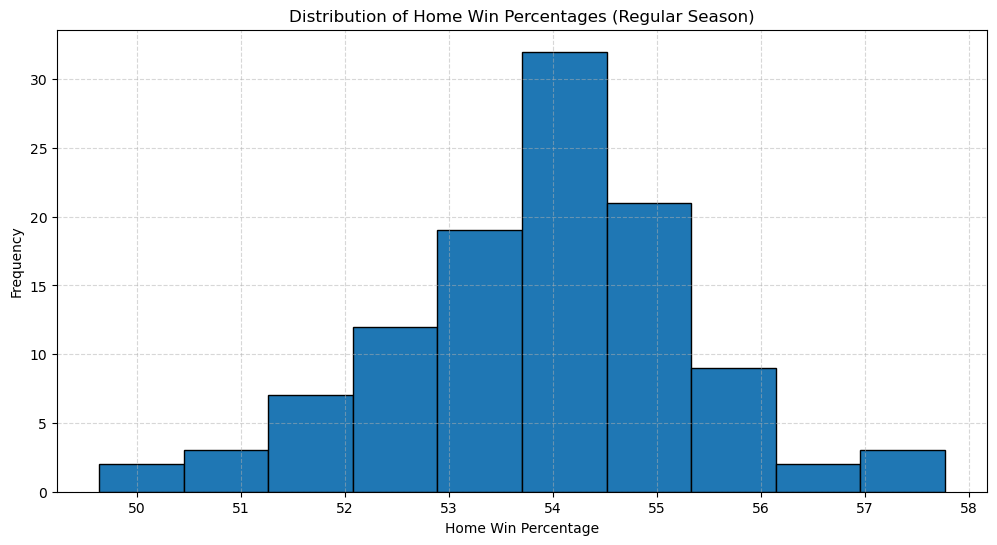

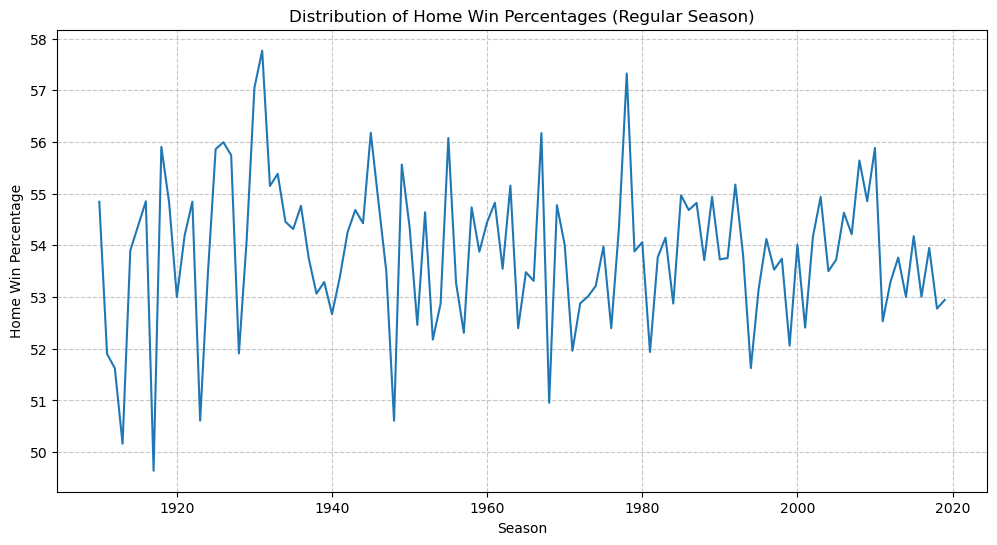

In [789]:
# Create df with only regular season data

reg_season_df = filtered_data[filtered_data['playoff'].isnull()]

# Create title, fig1, fig2 variables

reg_title = 'Distribution of Home Win Percentages (Regular Season)'
reg_fig1 = 'output_data/reg_fig1.png'
reg_fig2 = 'output_data/reg_fig2.png'

# Invoke function

home_percentage_season = home_team_advantage(reg_season_df, reg_title, reg_fig1, reg_fig2)

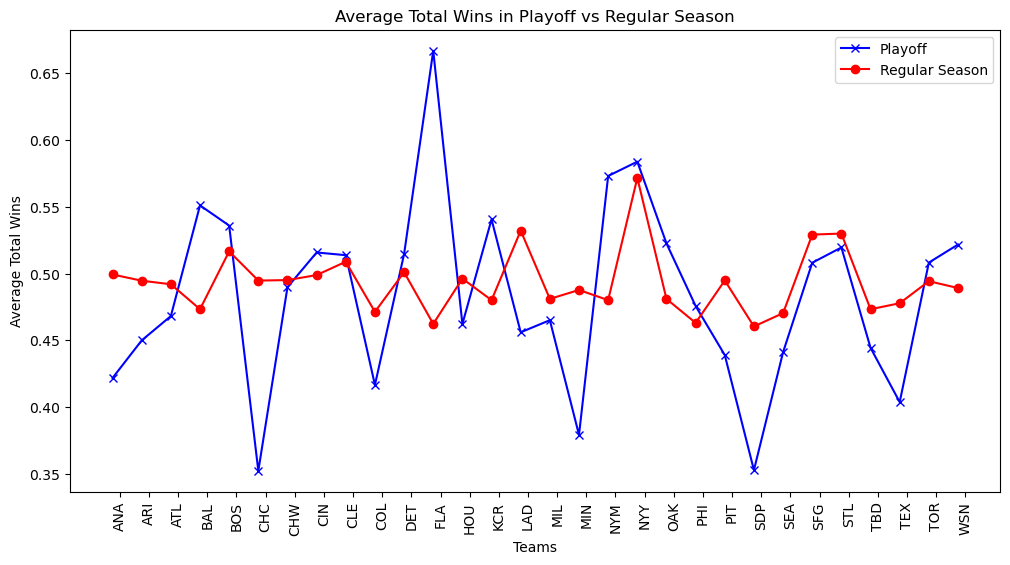

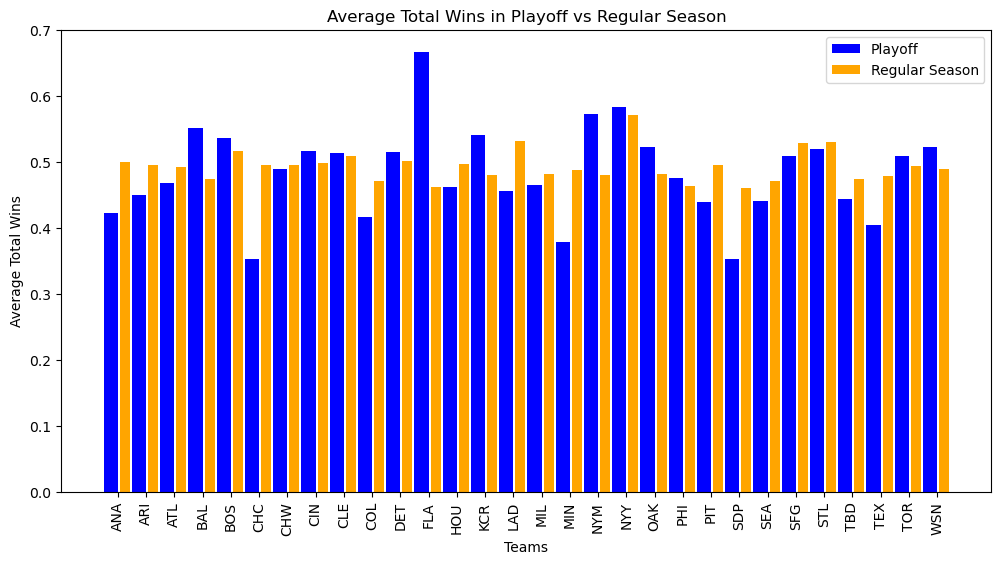

In [805]:
home_vs_away_df = pd.DataFrame({
    'home playoff': playoff_df['team1'],
    'home playoff score': playoff_df['score1'].astype(int),
    'away playoff': playoff_df['team2'],
    'away playoff score': playoff_df['score2'].astype(int),
    'home regular': reg_season_df['team1'],
    'home regular score': reg_season_df['score1'].astype(int),
    'away regular': reg_season_df['team2'],
    'away regular score': reg_season_df['score2'].astype(int)
})

# Compare playoff and regular home wins against against away wins
# Count total wins in series using value_counts

playoff_games_played = home_vs_away_df['home playoff'].value_counts() + home_vs_away_df['away playoff'].value_counts()
regular_games_played = home_vs_away_df['home regular'].value_counts() + home_vs_away_df['away regular'].value_counts()

playoff_home_wins = home_vs_away_df['home playoff'][home_vs_away_df['home playoff score'] > home_vs_away_df['away playoff score']].value_counts()
playoff_away_wins = home_vs_away_df['away playoff'][home_vs_away_df['away playoff score'] > home_vs_away_df['home playoff score']].value_counts()
regular_home_wins = home_vs_away_df['home regular'][home_vs_away_df['home regular score'] > home_vs_away_df['away regular score']].value_counts()
regular_away_wins = home_vs_away_df['away regular'][home_vs_away_df['away regular score'] > home_vs_away_df['home regular score']].value_counts()

# Add total wins between the playoff and regular home wins series 

playoff_total_wins = playoff_home_wins.add(playoff_away_wins)
regular_total_wins = regular_home_wins.add(regular_away_wins)

playoff_wins_avg = playoff_total_wins.div(playoff_games_played)
regular_wins_avg = regular_total_wins.div(regular_games_played)

# Set figure size 

plt.figure(figsize=(12, 6))

# Sort indices alphabetically and set the team names 

teams = sorted(set(playoff_total_wins.index) | set(regular_total_wins.index))



# Use .get() on playoff and regular season series to loop through and get win counts

# playoff_wins_count = [playoff_total_wins.get(team) for team in teams]
# regular_wins_count = [regular_total_wins.get(team) for team in teams]

playoff_wins_count_avg = [playoff_wins_avg.get(team) for team in teams]
regular_wins_count_avg = [regular_wins_avg.get(team) for team in teams]

# Plot line graph

plt.plot(teams, playoff_wins_count_avg, marker='x', label='Playoff', color='blue')
plt.plot(teams, regular_wins_count_avg, marker='o', label='Regular Season', color='red')

plt.xlabel('Teams')
plt.ylabel('Average Total Wins')
plt.title('Average Total Wins in Playoff vs Regular Season')
plt.xticks([i + 0.5 / 2 for i in range(len(teams))], teams, rotation=90)
plt.legend(loc='best')
plt.savefig('output_data/wins_playoff_vs_reg_line.png')
plt.show()

# Create bar graph using length of sorted teams list
plt.figure(figsize=(12, 6))

plt.bar(range(len(teams)), playoff_wins_count_avg, width=0.5, label='Playoff', color='blue')

# Plot regular bar by looping through teams and pushing bar to right of playoff bar

plt.bar([i + 0.5 for i in range(len(teams))], regular_wins_count_avg, width=bar_width, label='Regular Season', color='orange')

plt.xlabel('Teams')
plt.ylabel('Average Total Wins')
plt.title('Average Total Wins in Playoff vs Regular Season')
plt.xticks([i + 0.5 / 2 for i in range(len(teams))], teams, rotation=90)
plt.legend(loc='best')
plt.savefig('output_data/wins_playoff_vs_reg_bar.png')
plt.show()


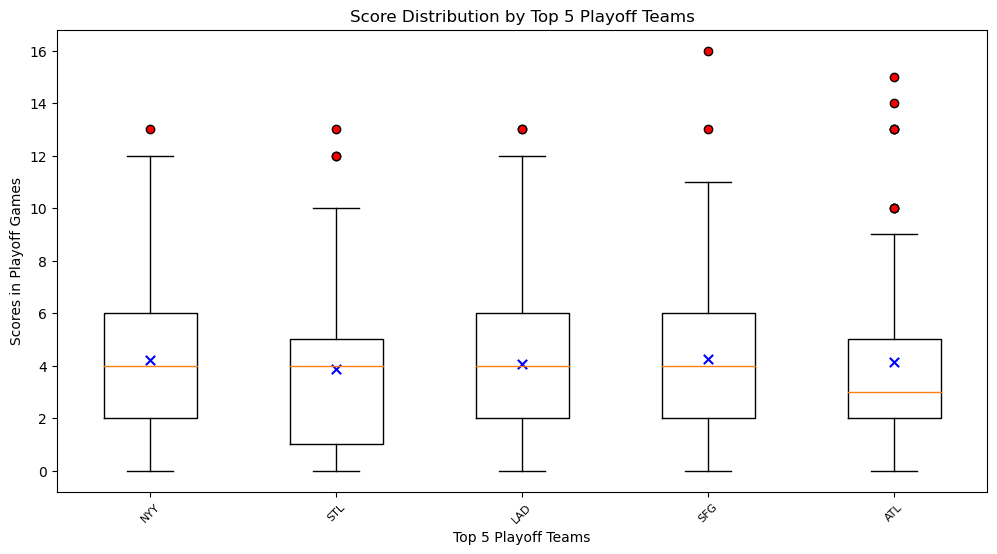

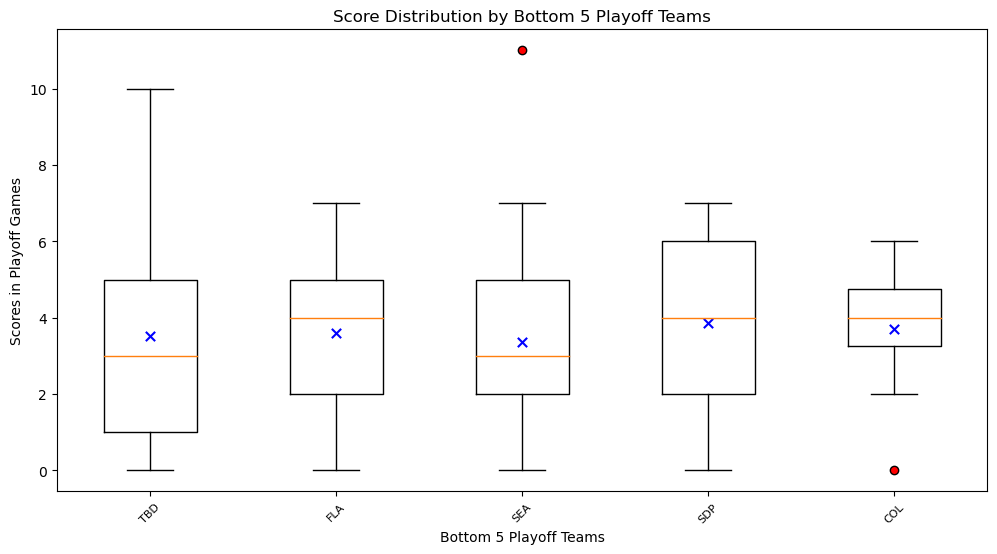

In [1032]:
playoff_summary = playoff_df.groupby('team1')['score1'].agg(['mean', 'median', 'var', 'std', 'sem'])

teams_list = ['NYY', 'STL', 'LAD', 'SFG', 'ATL']

score_list = []

for team in teams_list:
    team_playoff_data = playoff_df[playoff_df['team1'] == team]
    
    scores_count = team_playoff_data['score1']
    quartiles = scores_count.quantile([0.25,0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    upper_b = upperq + (1.5 * iqr)
    lower_b = lowerq - (1.5 * iqr)
    
    outliers = scores_count[(scores_count < lower_b) | (scores_count > upper_b)]
    score_list.append(scores_count.tolist())

plt.figure(figsize=(12, 6))
    
box_playoff = plt.boxplot(score_list)

for outlier in box_playoff['fliers']:
    outlier.set(marker='o', markerfacecolor='red', markeredgecolor='black')
for i, score in enumerate(score_list):
    mean_val = sum(score) / len(score)
    plt.scatter(i + 1, mean_val, marker='x', color='b', s=45)
plt.xticks(range(1, len(teams_list) + 1), teams_list, rotation=45, fontsize=8)
plt.xlabel('Top 5 Playoff Teams')
plt.ylabel('Scores in Playoff Games')
plt.title('Score Distribution by Top 5 Playoff Teams')
plt.savefig('output_data/box_top_5.png')
plt.show()

bottom_teams = ['TBD', 'FLA', 'SEA', 'SDP', 'COL']

score_list2 = []

for team in bottom_teams:
    bottom_team_data = playoff_df[playoff_df['team1'] == team]
    
    scores_count2 = bottom_team_data['score1']
    quartiles = scores_count.quantile([0.25,0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    upper_b = upperq + (1.5 * iqr)
    lower_b = lowerq - (1.5 * iqr)
    
    outliers = scores_count2[(scores_count2 < lower_b) | (scores_count2 > upper_b)]
    score_list2.append(scores_count2.tolist())


plt.figure(figsize=(12, 6))  

box_playoff = plt.boxplot(score_list2)

for outlier in box_playoff['fliers']:
    outlier.set(marker='o', markerfacecolor='red', markeredgecolor='black')
for i, score in enumerate(score_list2):
    mean_val = sum(score) / len(score)
    plt.scatter(i + 1, mean_val, marker='x', color='b', s=45)
plt.xticks(range(1, len(bottom_teams) + 1), bottom_teams, rotation=45, fontsize=8)
plt.xlabel('Bottom 5 Playoff Teams')
plt.ylabel('Scores in Playoff Games')
plt.title('Score Distribution by Bottom 5 Playoff Teams')
plt.savefig('output_data/box_bottom_5.png')
plt.show()
 
# How much more do top 5 teams score compared to lower 5 playoff teams 

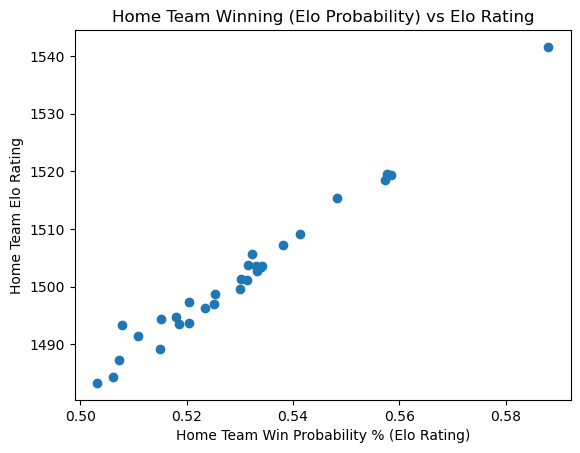

In [730]:
avg_win_prob = filtered_data.groupby('team1')['elo_prob1'].mean()
post_game_elo_avg = filtered_data.groupby('team1')['elo1_post'].mean()
plt.scatter(avg_win_prob, post_game_elo_avg)
plt.xlabel('Home Team Win Probability % (Elo Rating)')
plt.ylabel('Home Team Elo Rating')
plt.title('Home Team Winning (Elo Probability) vs Elo Rating')
plt.show()


The r-value is: 0.9778733682548997


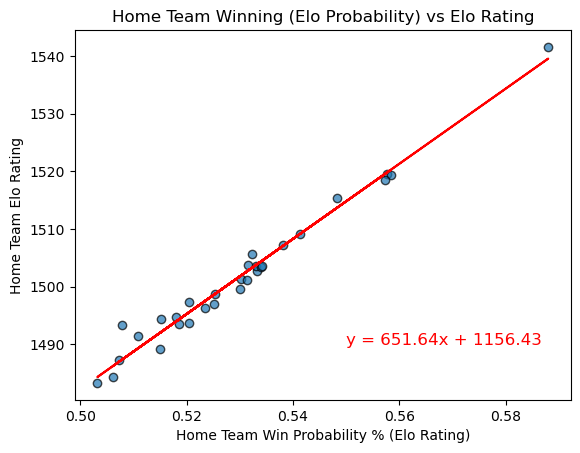

In [731]:
plt.scatter(avg_win_prob, post_game_elo_avg, edgecolor='black', alpha=0.7)
plt.xlabel('Home Team Win Probability % (Elo Rating)')
plt.ylabel('Home Team Elo Rating')
plt.title('Home Team Winning (Elo Probability) vs Elo Rating')

slope, intercept, r_value, p_value, std_err = linregress(avg_win_prob, post_game_elo_avg)
reg_line = slope * avg_win_prob + intercept
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', (0.55, 1490), fontsize=12, color='red')
plt.plot(avg_win_prob, reg_line, color='red')

print(f"The r-value is: {r_value**2}")
plt.savefig('output_data/elo_linregress.png') 
plt.show()
    

In [732]:
# Get API url from sportsdata.io and create endpoint with params

base_url = 'https://api.sportsdata.io/v3/mlb/scores/json/Stadiums?'
params = {
    'key': api_key
}

# Call get request and save response to variable in json

response = requests.get(base_url, params=params)
response = response.json()
# print(json.dumps(response[0], indent=4, sort_keys=True))

# Create dictionary that records stadium city, altitude and stadium ID

city_altitude = {
    'stadium city':[],
    'altitude': [],
    'stadium ID':[]
}

# Loop through api and append values to each key in the dictionary above

for i in range(len(response)):
    city = response[i]['City']
    altitude = response[i]['Altitude']
    stadiumID = response[i]['StadiumID']
    
    if (altitude is not None):
        city_altitude['stadium city'].append(city)
        city_altitude['altitude'].append(altitude)
        city_altitude['stadium ID'].append(stadiumID)
# print(json.dumps(city_altitude, indent=4))

# Create df from above dictionary and output to csv 

city_alt_df = pd.DataFrame(city_altitude)
city_alt_df.to_csv('output_data/city_altitude.csv', index=False)

In [733]:
# Get API url from sportsdata.io and create endpoint with params

base_url = 'https://api.sportsdata.io/v3/mlb/scores/json/teams?'
params = {
    'key': api_key
}

# Call get request and save response to variable in json

response = requests.get(base_url, params=params)
response = response.json()
# print(json.dumps(response, indent=4, sort_keys=True))

# Create dictionary that records team city, team, team key and stadium ID

city_team = {
    'team city':[],
    'team':[],
    'team key':[],
    'stadium ID':[]
}

# Loop through api and append values to each key in the dictionary above

for i in range(len(response)):
    city = response[i]['City']
    team = response[i]['Name']
    key = response[i]['Key']
    stadiumID = response[i]['StadiumID']
    
    city_team['team city'].append(city)
    city_team['team'].append(team)
    city_team['team key'].append(key)
    city_team['stadium ID'].append(stadiumID)
    
# print(json.dumps(city_team, indent=4))

# Create df from above dictionary and output to csv 

city_alt_df = pd.DataFrame(city_team)
city_alt_df.to_csv('output_data/team_name.csv', index=False)  

In [734]:
# Get API url from sportsdata.io and create endpoint with params

base_url5 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2019?'
base_url6 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2018?'
base_url7 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2017?'
base_url4 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2020?'
base_url3 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2021?'
base_url2 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2022?'
base_url1 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2023?'

params = {
    'key': api_key
}

response1 = requests.get(base_url1, params=params)
response1 = response1.json()

# print(json.dumps(response2[0], indent=4, sort_keys=True))

# Create dictionary that records team city, team, team key and stadium ID

team_standings = {
    'team key':[],
    'league':[],
    'wins':[],
    'runs scored':[],
    'season':[]
}

def append_standings(url):
    response = requests.get(url, params=params)
    response = response.json()

    team_standings = {
        'team key': [],
        'league': [],
        'wins': [],
        'runs scored': [],
        'season': []
    }

    for i in range(len(response)):
        league = response[i]['League']
        runs_scored = response[i]['RunsScored']
        key = response[i]['Key']
        wins = response[i]['Wins']
        season = response[i]['Season']

        team_standings['league'].append(league)
        team_standings['runs scored'].append(runs_scored)
        team_standings['team key'].append(key)
        team_standings['wins'].append(wins)
        team_standings['season'].append(season)
    
    return team_standings

def merge_standings(base_urls):
    combined_standings = {
        'team key': [],
        'league': [],
        'wins': [],
        'runs scored': [],
        'season': []
    }
    
    for url in base_urls:
        standings_data = append_standings(url)
        for key in combined_standings:
            combined_standings[key].extend(standings_data[key])
    
    return combined_standings

# Combining the data from all base URLs

base_urls = [base_url1, base_url2, base_url3, base_url4, base_url5, base_url6,  base_url7]
team_standings_combined = merge_standings(base_urls)


team_standings_combined = pd.DataFrame(team_standings_combined)
team_standings_combined.to_csv('output_data/team_standings.csv', index=False) 
team_standings_combined.head()


,team key,league,wins,runs scored,season
0,MIN,AL,87,778,2023
1,DET,AL,78,661,2023
2,CLE,AL,76,662,2023
3,CHW,AL,61,641,2023
4,KC,AL,56,676,2023


In [735]:
complete_sportsio_df.describe()

,stadium ID,altitude,wins,runs scored,season
count,210.000000,210.000000,210.000000,210.000000,210.000000
mean,41.566667,515.833333,73.700000,672.738095,2020.000000
std,24.627907,940.049147,22.171591,178.170509,2.004779
min,1.000000,6.000000,19.000000,219.000000,2017.000000
25%,23.000000,17.000000,64.250000,642.750000,2018.000000
50%,38.000000,353.000000,78.000000,718.000000,2020.000000
75%,62.000000,602.000000,90.000000,777.250000,2022.000000
max,93.000000,5211.000000,111.000000,947.000000,2023.000000


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

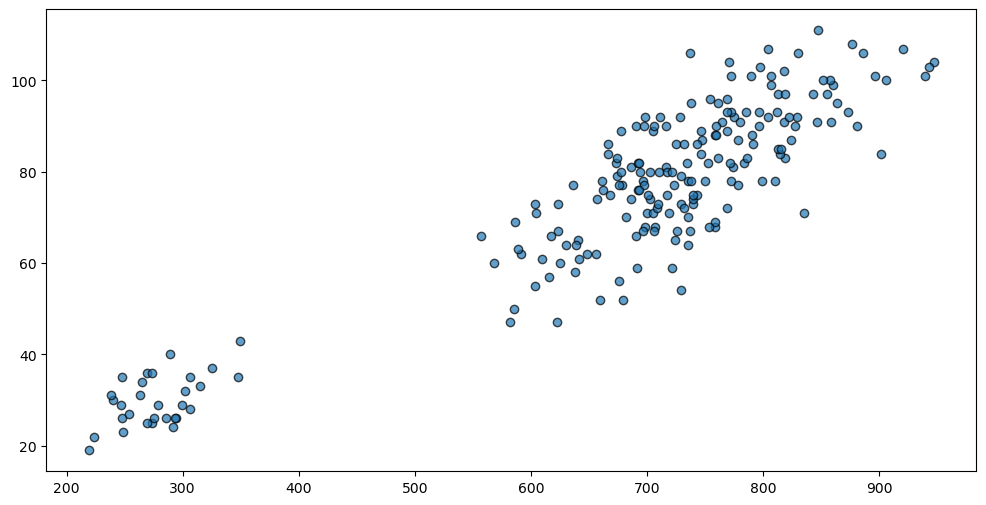

In [796]:
# Create scatter plot for runs scored vs wins over 7 seasons
plt.figure(figsize=(12, 6))
plt.scatter(complete_sportsio_df['runs scored'], complete_sportsio_df['wins'], edgecolor='black', alpha=0.7)
plt.xlabel


The r-value is: 0.8410559202737745


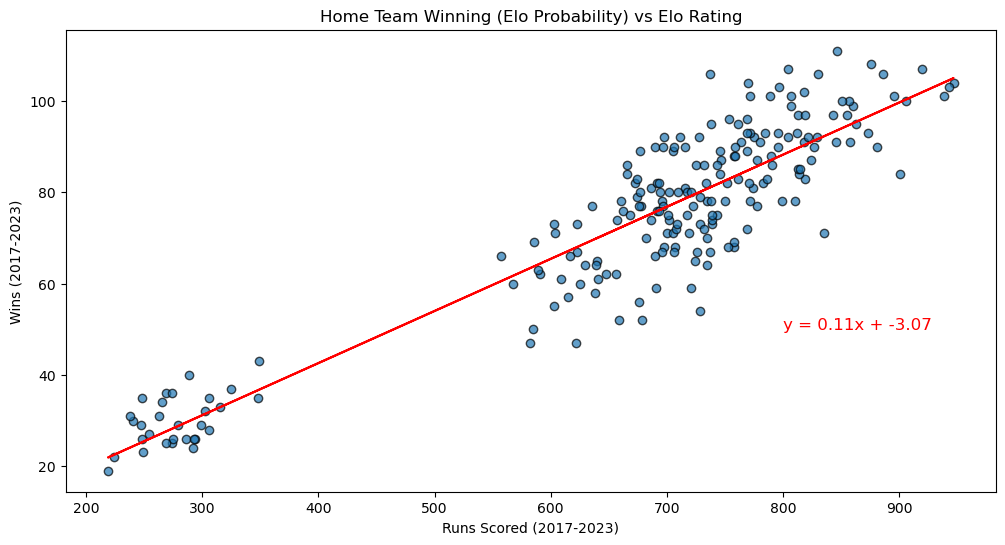

In [800]:
plt.figure(figsize=(12, 6))
plt.scatter(complete_sportsio_df['runs scored'], complete_sportsio_df['wins'], edgecolor='black', alpha=0.7)
plt.xlabel('Runs Scored (2017-2023)')
plt.ylabel('Wins (2017-2023)')
plt.title('Home Team Winning (Elo Probability) vs Elo Rating')

slope, intercept, r_value, p_value, std_err = linregress(complete_sportsio_df['runs scored'], complete_sportsio_df['wins'])
reg_line = slope * complete_sportsio_df['runs scored'] + intercept
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', (800, 50), fontsize=12, color='red')
plt.plot(complete_sportsio_df['runs scored'], reg_line, color='red')

print(f"The r-value is: {r_value**2}")
plt.savefig('output_data/elo_linregress.png') 
plt.show()


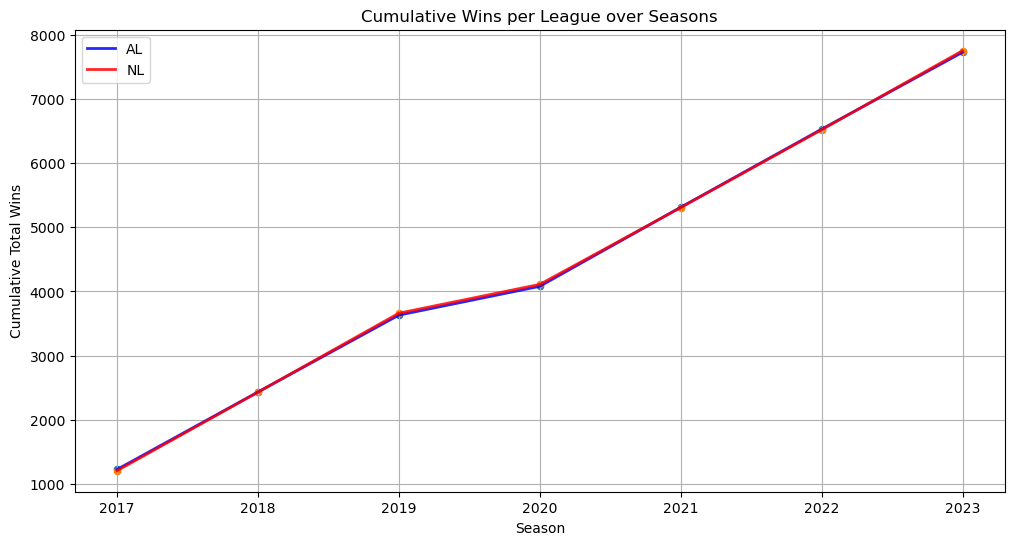

In [801]:
leagues = team_standings_combined['league'].unique()

# Create a dictionary to store wins for each league over the seasons

league_wins = {}
color = ['blue', 'red']

# Calculate wins for each league over the seasons
plt.figure(figsize=(12, 6))

for league in leagues:
    league_data = team_standings_combined[team_standings_combined['league'] == league]
    cumulative_wins = league_data.groupby('season')['wins'].sum().cumsum()
    league_wins[league] = cumulative_wins
for i, (league, wins) in enumerate(league_wins.items()):
    plt.plot(wins.index, wins.values, label=league, linewidth=2, alpha=0.85, color=color[i])
    plt.scatter(wins.index, wins.values, s=20) 

plt.xlabel('Season')
plt.ylabel('Cumulative Total Wins')
plt.title('Cumulative Wins per League over Seasons')
plt.legend()
plt.grid(True)
plt.savefig('output_data/league_cumulative.png') 
plt.show()


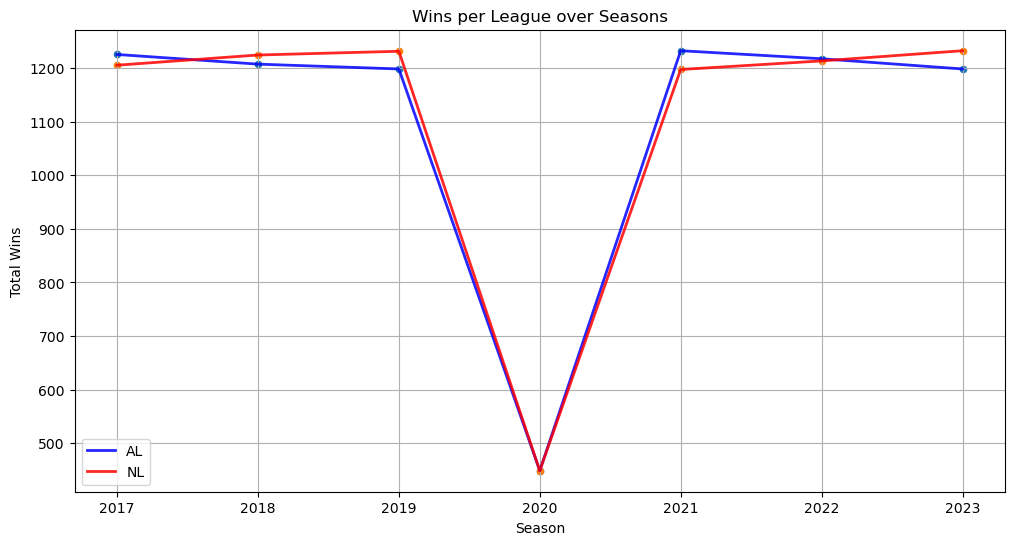

In [1035]:
leagues = team_standings_combined['league'].unique()

# Create a dictionary to store wins for each league over the seasons

league_wins = {}
color = ['blue', 'red']

# Calculate wins for each league over the seasons
plt.figure(figsize=(12, 6))

for league in leagues:
    league_data = team_standings_combined[team_standings_combined['league'] == league]
    total_wins = league_data.groupby('season')['wins'].sum()
    league_wins[league] = total_wins
for i, (league, wins) in enumerate(league_wins.items()):
    plt.plot(wins.index, wins.values, label=league, linewidth=2, alpha=0.85, color=color[i])
    plt.scatter(wins.index, wins.values, s=20) 

plt.xlabel('Season')
plt.ylabel('Total Wins')
plt.title('Wins per League over Seasons')
plt.legend()
plt.grid(True)
plt.savefig('output_data/wins_per_league_covid.png')
plt.show()